In [8]:
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import pandas as pd
import os
import re
import rapidfuzz
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

In [9]:
filelist = pd.read_csv("ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
141332            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
141333    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
141334    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
141335    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
141336        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
Name: 0, Length: 141337, dtype: 

In [10]:
def check_filename(filename):
    if "Taranaki" in filename:
        return False
    else:
        match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
        return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
1344,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp
1368,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp
1371,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp
1375,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp
1385,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp
...,...
140119,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29MAR2018.shp
140123,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp
140131,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_21MAY2015.shp
140136,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_27MAR2009.shp


In [4]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

236       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
237       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
239         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
242         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
254         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
141319            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
141325            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
141328            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
141329            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
141332            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 1905, dtype: ob

In [11]:
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", "_cliff", "_beach", "_beachcliffsegment", "_MF", "_MT"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print(sum(df.match_score == 100))
print(sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

713
172


In [12]:
gdf = gpd.read_file("shorelines.geojson").dissolve(by="filename").reset_index()
gdf

,filename,geometry,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,Uncertaint,UNCY,Length,Photoscale,Pixel_ER,Georef_ER,Dig_ER,Total_UNCY,Date_,OBJECTID,Shape_Leng,SN,SourceFile,Year_,Month_,Day_,Date2,Shape_Le_1,DSAS_NZDAT,OBJECTID_1
0,Auckland/BrownsBay/Shorelines/BrownsBay_20MAR1988.shp,"MULTILINESTRING ((174.75123 -36.71079, 174.75107 -36.71093, 174.75071 -36.71128, 174.75049 -36.71147, 174.75039 -36.71163, 174...",0,Auckland,BrownsBay,1988-03-20,None,MT,1000,Very difficult to identify cliff top,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
1,Auckland/KarekareBethells/Shorelines/KarekareBethells_02JAN2004.shp,"MULTILINESTRING ((174.44669 -36.89126, 174.44625 -36.89155, 174.44576 -36.89177, 174.44510 -36.89201, 174.44477 -36.89212, 174...",0,Auckland,Bethells Beach,2004-01-02,None,MW,2000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
2,Auckland/KarekareBethells/Shorelines/KarekareBethells_09AUG1955.shp,"MULTILINESTRING ((174.44900 -36.90415, 174.44900 -36.90427, 174.44893 -36.90433, 174.44887 -36.90440, 174.44898 -36.90446, 174...",0,Auckland,Wigmore Bay,1955-08-09,None,MW,3000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
3,Auckland/KarekareBethells/Shorelines/KarekareBethells_14APR1940.shp,"MULTILINESTRING ((174.44434 -36.89390, 174.44438 -36.89398, 174.44447 -36.89405, 174.44453 -36.89413, 174.44464 -36.89422, 174...",0,Auckland,Bethells Beach,1940-04-14,None,MW,2000,"Northern end of beach missing from mosaic, Difficult to distinguish toe of dune",RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
4,Auckland/KarekareBethells/Shorelines/KarekareBethells_19AUG1960.shp,"MULTILINESTRING ((174.46894 -36.95319, 174.46885 -36.95313, 174.46862 -36.95313, 174.46849 -36.95304, 174.46838 -36.95294, 174...",0,Auckland,Piha Beach (north),1960-08-19,None,Mw,2000,tod,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_15JAN1988.shp,"MULTILINESTRING ((171.67547 -41.73801, 171.67541 -41.73795, 171.67527 -41.73789, 171.67521 -41.73785, 171.67516 -41.73777, 171...",0,WestCoast,WhareateaRiver,1988-01-15,None,ER,1000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
834,WestCoast/WhareateaRiver/Shorelines/WhareateaRiver_25NOV1974.shp,"MULTILINESTRING ((171.71569 -41.72124, 171.71545 -41.72114, 171.71528 -41.72091, 171.71528 -41.72070, 171.71522 -41.72043, 171...",0,WestCoast,WhareateaRiver,1974-11-25,None,ER,2000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
835,WestCoast/WoodpeckerBay/Shorelines/WoodpeckerBay_17APR1976_mosaic.shp,"MULTILINESTRING ((171.40552 -41.98601, 171.40564 -41.98604, 171.40568 -41.98608, 171.40567 -41.98615, 171.40566 -41.98622, 171...",0,WestCoast,WoodpeckerBay,1976-04-17,None,MD,1000,Edge Veg,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN
836,WestCoast/WoodpeckerBay/Shorelines/WoodpeckerBay_18FEB1988_mosaic.shp,"LINESTRING (171.40564 -41.98606, 171.40563 -41.98623, 171.40568 -41.98630, 171.40562 -41.98634, 171.40559 -41.98639, 171.40569...",0,WestCoast,WoodpeckerBay,1988-02-18,None,MD,1000,Edge Veg,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN


In [13]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
sample

,filename,matched_image,match_score
133478,Retrolens/Bay of Plenty/Whakatane/Shorelines/Whakatane_26SEP1944.shp,Retrolens/Bay of Plenty/Whakatane/Stack/Whakatane_26SEP1944_mosaic.jp2,100.0


In [20]:
shapefile_path = sample.filename.iloc[0]
sample_gdf = gdf["Retrolens/" + gdf.filename == shapefile_path]
sample_gdf

,filename,geometry,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,Uncertaint,UNCY,Length,Photoscale,Pixel_ER,Georef_ER,Dig_ER,Total_UNCY,Date_,OBJECTID,Shape_Leng,SN,SourceFile,Year_,Month_,Day_,Date2,Shape_Le_1,DSAS_NZDAT,OBJECTID_1
133,Bay of Plenty/Whakatane/Shorelines/Whakatane_26SEP1944.shp,"MULTILINESTRING ((177.01248 -37.94241, 177.01244 -37.94257, 177.01235 -37.94263, 177.01232 -37.94272, 177.01214 -37.94292, 177...",0,Bay of Plenty,Whakatane,1944-09-26,None,ER,1000,None,RL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,None,None,None,NaN,None,NaN


In [15]:
image_filepath = sample.matched_image.iloc[0]
image_filepath

'Retrolens/Bay of Plenty/Whakatane/Stack/Whakatane_26SEP1944_mosaic.jp2'

In [16]:
image = rio.open(image_filepath)
image

<open DatasetReader name='Retrolens/Bay of Plenty/Whakatane/Stack/Whakatane_26SEP1944_mosaic.jp2' mode='r'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


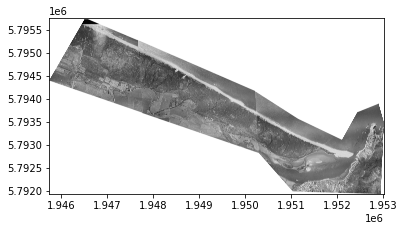

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

In [21]:
ax = rasterio.plot.show(image)
sample_gdf.plot(ax=ax)